# Assessing distribution / usage of Foursquare in German cities
## Capstone Project Report

## 1. Introduction / Business Problem

#### Background

Foursquare relies on users to add, describe, rate,... places.

It is not a widely used service in Germany. Therefore, probably not every city in Germany as an adequate large database which one can use to compare it to other cities.

#### Business problem

This project will assess the properties of German cities with a population of > 100,000 people and their respective Foursquare venues data to give insights into the following questions:

* How much and what type of Foursquare Places data can a data scientist use to compare German cities?
* What are the limits of this comparison?
* Can one cluster the cities to enable data scientist to decide which cities are better suited for comparison than others? In which properties do the city clusters differ?
* Can one select cities that should be targeted with an ad campaign to promote the usage of Foursquare to expand the database?

#### Stakeholders

The two stakeholders this data science project will target are:

1. a "data scientist"
  * to decide whether he/she wants to use Foursquare for comparing cities in Germany
  * ... or to limit his/her comparison to (clusters of) cities with specific properties (population size, location, venues,...)


2. a "Foursquare advertising team"
  * to select cities in which to promote the usage of Foursquare

## 2. Data

### Data sources

The list from Wikipedia is the basis for the analysis.
It includes all German cities with a population of > 100,000 (definition of "Großstadt").
This project will use the city name, the population data from 2018, the area (sqkm), and the federal state.

* [List of German cities defined as "Großstadt" from Wikipedia](https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland#Tabelle)
   * Name of City
   * Population (latest data from 2018)
   * Area of city (2016 data)

To have some more information about the population of the cities the age distribution will be added.
A difference in age groups may be one factor leading to different usage of Foursquare.
Due to complexity, the age distribution will be simplified into two groups: "< 40 years" and "> 40 years".
Although the age groups are only broken down to the state level and not the city level, they will be taken as representation for the cities.

* [Population by age groups by state](https://www.statistikportal.de/en/node/132)
   * State ("Bundesland")
   * Age groups

Using the city's name the geographic location will be retrieved with the help of Geopy / OpenStreetMap.
The location data will be used to show the cities on a map (Folium) and, of course, to retrieve the venues using the Foursquare API.

* [OpenStreetMap with Geopy (OSM Nominatim), using the city name](https://geopy.readthedocs.io/en/stable/)
   * Latitude
   * Longitude

Additionally, geojson information for the German federal states may be used for a choropleth map to display the difference in age groups per state.

* [German federal states geojson](http://opendatalab.de/projects/geojson-utilities/)
   * Geojson file: bundeslaender_simplify200.geojson

Finally, the venues for each city from Foursquare API will be added using their geo-locations.

**The Foursquare API restrictions limit the data that can be used for the project. E.g. the number of venues that can be retrieved per call per location is limited to 100.**

The search radius will also have an impact on the number of venues. For simplification, this parameter will be fix. The radius is calculated from the median size (area in sqkm) of the cities.

[Foursquare GET Venue Search](https://developer.foursquare.com/docs/api-reference/venues/search/)
   * parameters:
      * geolocation of city (longitude, latitude)
      * radius = tbd
      * limit = (as many as possible)
   * data: 
      * venue name
      * primary category of venue

#### Importing the modules and packages.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim
import folium

import json
import requests
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

### Exploring the data

**Importing the data from week 1 (saved as csv file)**

In [2]:
cities_age_venues_grouped = pd.read_csv('cities_age_venues_grouped.csv', index_col=0)
print(cities_age_venues_grouped.shape)
cities_age_venues_grouped.head()

(79, 15)


,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Venues,Venues per Population,Venues per Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berlin,3644826,891.68,52.517036,13.388860,Berlin,45.3,100.0,2.743615,0.112148,Coffee Shop,Bookstore,Park,Ice Cream Shop,Monument / Landmark
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,100.0,5.431302,0.132412,Hotel,Café,Coffee Shop,Seafood Restaurant,Vietnamese Restaurant
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,100.0,6.795750,0.321854,Café,Plaza,Hotel,Ice Cream Shop,German Restaurant
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,100.0,19.291426,0.536538,Park,Café,Coffee Shop,Gym / Fitness Center,Bakery
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,100.0,33.882799,0.681013,Italian Restaurant,Steakhouse,Beer Garden,German Restaurant,Café


**Showing the cities on the map**

In [3]:
# split dataframe in cities with 100 venues and <100 venues
cities_age_venues_grouped_100 = cities_age_venues_grouped.loc[cities_age_venues_grouped['Venues']==100]
cities_age_venues_grouped_less100 = cities_age_venues_grouped.loc[cities_age_venues_grouped['Venues']<100]
print('Shape of dataframe with cities with 100 venues:', cities_age_venues_grouped_100.shape)
print('Shape of dataframe with cities with less than 100 venues:', cities_age_venues_grouped_less100.shape)

Shape of dataframe with cities with 100 venues: (43, 15)
Shape of dataframe with cities with less than 100 venues: (30, 15)


Description: With this first simple clustering by venue count one can see that most of the cities that reach the limit of 100 venues are located in the west and south of Germany, while the other cities seem to be distributed more evenly.

**Map of the cities grouped by venue count and underlying choropleth map for the federal states by share of young people of the total population.**

In [4]:
map_fed_cities = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# generate choropleth map
map_fed_cities.choropleth(
    geo_data=r'bundeslaender_simplify200.geojson',
    data=cities_age_venues_grouped,
    columns=['State' , 'Population Share Age <40'],
    key_on='feature.properties.GEN',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Share Age <40 years of age'
)

# add markers for cities with 100 venues
for lat, lng, city, pop, vens in zip(cities_age_venues_grouped_100['Latitude'], cities_age_venues_grouped_100['Longitude'], cities_age_venues_grouped_100['City'], cities_age_venues_grouped_100['Population'], cities_age_venues_grouped_100['Venues']):
    label = '{} (Population: {}, Venues: {})'.format(city, pop, vens)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fed_cities)

# add markers for cities with less than 100 venues
for lat, lng, city, pop, vens in zip(cities_age_venues_grouped_less100['Latitude'], cities_age_venues_grouped_less100['Longitude'], cities_age_venues_grouped_less100['City'], cities_age_venues_grouped_less100['Population'], cities_age_venues_grouped_less100['Venues']):
    label = '{} (Population: {}, Venues: {})'.format(city, pop, vens)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#CC7731',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fed_cities)
    
map_fed_cities

/home/lars/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


**Statistical summary of the dataframe.**

In [5]:
cities_age_venues_grouped.describe().round(3)

,Population,Area,Latitude,Longitude,Population Share Age <40,Venues,Venues per Population,Venues per Area
count,79.000,79.000,79.000,79.000,79.000,73.000,73.000,73.000
mean,333781.342,173.172,50.968,8.978,42.423,88.945,44.617,0.678
std,474787.744,129.769,1.439,1.950,2.003,17.981,20.491,0.334
min,100194.000,44.890,47.996,6.084,36.700,17.000,2.744,0.076
25%,127038.500,99.700,49.833,7.196,42.100,82.000,31.815,0.475
50%,201585.000,141.060,51.198,8.587,42.700,100.000,46.795,0.622
75%,313705.500,205.745,51.700,10.441,43.700,100.000,57.888,0.882
max,3644826.000,891.680,54.323,13.738,47.100,100.000,89.316,1.945


**Scatterplot of population size vs. venues, venues per population, and venues per area with a logarithmic scale of the x-axis (population).**

**Population size vs. venue count:**

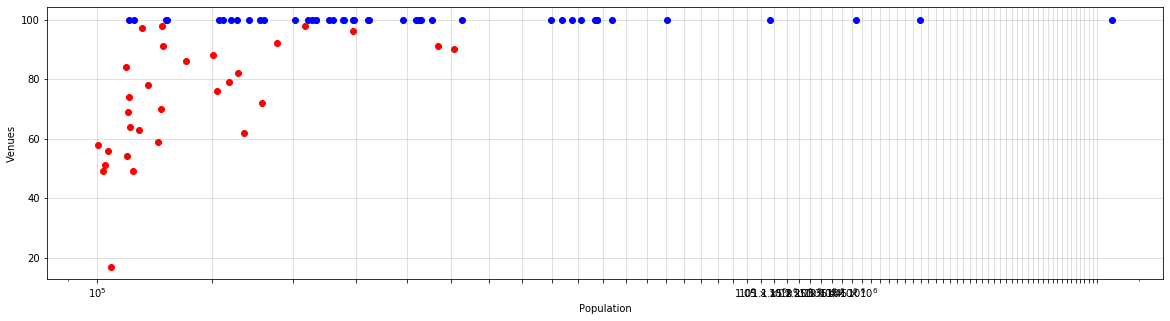

In [6]:
x_data1 = cities_age_venues_grouped_100['Population']
y_data1 = cities_age_venues_grouped_100['Venues']

x_data2 = cities_age_venues_grouped_less100['Population']
y_data2 = cities_age_venues_grouped_less100['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca(xscale='log', xticks=np.arange(0,3500000,50000))
ax.plot(x_data1, y_data1, 'o', c='blue')
ax.plot(x_data2, y_data2, 'o', c='red')
ax.set_xlabel('Population')
ax.set_ylabel('Venues')
ax.grid(alpha=0.5)

Except for two cities every city with a population bigger than 250k reaches the limit of 100 venue counts (blue dots). Cities with <100 venues (red dots) are mainly small cities (population-wise).

**Area vs. venue count:**

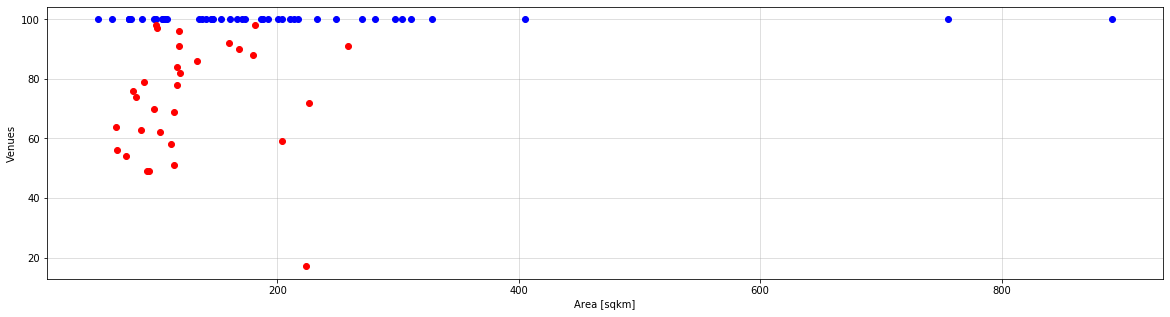

In [7]:
x_data1 = cities_age_venues_grouped_100['Area']
y_data1 = cities_age_venues_grouped_100['Venues']

x_data2 = cities_age_venues_grouped_less100['Area']
y_data2 = cities_age_venues_grouped_less100['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(x_data1, y_data1, 'o', c='blue')
ax.plot(x_data2, y_data2, 'o', c='red')
ax.set_xlabel('Area [sqkm]')
ax.set_ylabel('Venues')
ax.grid(alpha=0.5)

When plotted by area, a lot of small cities reach the limit of 100 venues. The area doesn't seem to make a difference.

**Venues per population vs. venues per area:**

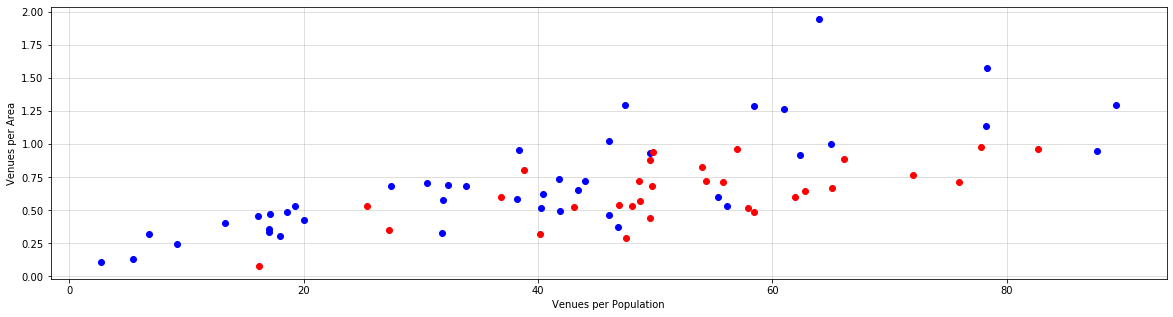

In [8]:
x_data1 = cities_age_venues_grouped_100['Venues per Population']
y_data1 = cities_age_venues_grouped_100['Venues per Area']

x_data2 = cities_age_venues_grouped_less100['Venues per Population']
y_data2 = cities_age_venues_grouped_less100['Venues per Area']

fig = plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(x_data1, y_data1, 'o', c='blue')
ax.plot(x_data2, y_data2, 'o', c='red')
ax.set_xlabel('Venues per Population')
ax.set_ylabel('Venues per Area')
ax.grid(alpha=0.5)

If one plots the two derived "venue densities" venues per population vs. venues per area one can see that there are two cities that have both a very low density per population and per area. More of the 100-venues-cities show up in regions of higher density. Still, most of the cities of both groups are in the same density region. So, even with these derived variables one cannot separate the groups or explain any difference.

**Venues vs. difference age groups:**

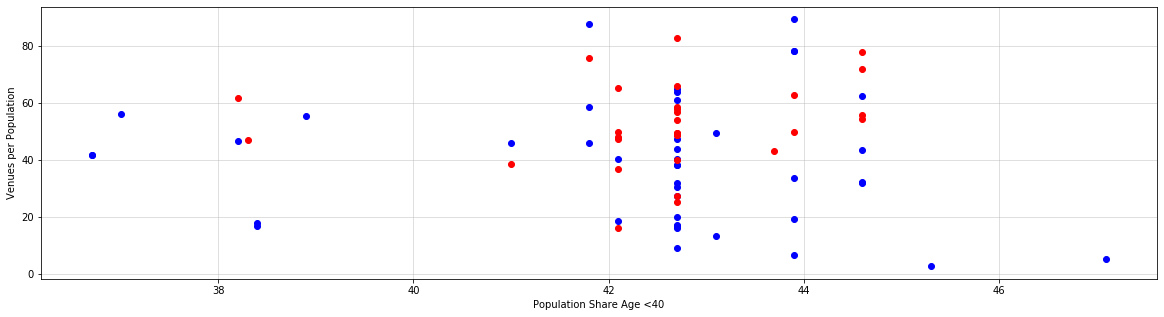

In [9]:
x_data1 = cities_age_venues_grouped_100['Population Share Age <40']
y_data1 = cities_age_venues_grouped_100['Venues per Population']

x_data2 = cities_age_venues_grouped_less100['Population Share Age <40']
y_data2 = cities_age_venues_grouped_less100['Venues per Population']

fig = plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(x_data1, y_data1, 'o', c='blue')
ax.plot(x_data2, y_data2, 'o', c='red')
ax.set_xlabel('Population Share Age <40')
ax.set_ylabel('Venues per Population')
ax.grid(alpha=0.5)

There are a few more cities with <100 venues (red dots) in the states with a lower population share <40 years than cities with >= 100 venues.

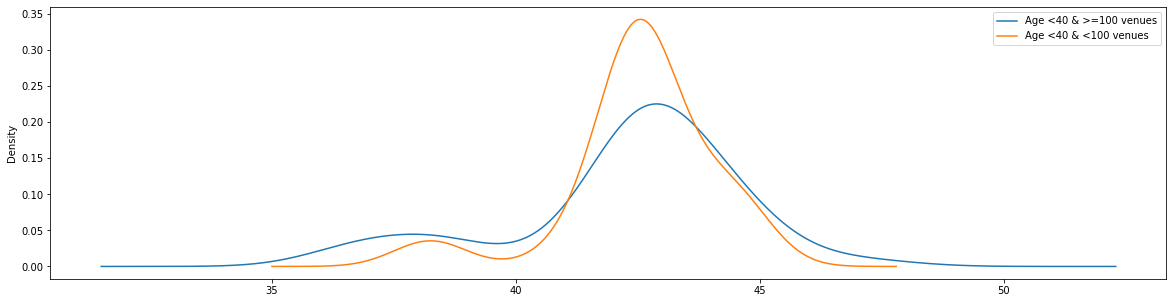

In [10]:
popshare = pd.DataFrame({'Age <40 & >=100 venues': cities_age_venues_grouped_100['Population Share Age <40'], 'Age <40 & <100 venues': cities_age_venues_grouped_less100['Population Share Age <40']})
ax = popshare.plot.kde(figsize=(20,5))

Description:
The density plot display this (marginal) difference a little better.
The 'bump' for the Age >40 years data is slightly higher at ~38% and lower at ~42%. 

## 3. Methodology

In the first step, we created a dataframe with all big cities in Germany, their properties, their location and their Foursquare venues.

**The limit of 100 venues per city per Foursquare API call distorts results while comparing he cities. Therefore, all cities with a venue count of 100 will not be included in the dataframe for further analysis. The reduced dataframe of cities with < 100 venues consists of 35 cities.**

In the second step, the 35 cities will be clustered into a **'manual' cluster** of 4 equal-sized groups **by quartiles of the parameter 'Population'** and also into **4 clusters by using the K-Means ML method**.

Lastly, the results of these two clusters will be compared regarding the cities properties and the top venues (limited to 10 cities and the top five venues).

## 4. Analysis

Selecting the columns that will be part of the analysis and K-means method.

In [11]:
cols = ['Population', 'Area', 'Population Share Age <40', 'Venues']

Calculating the quartiles for the selected columns for the 'manual' clustering.

In [12]:
quartiles = pd.DataFrame()

for i in range(len(cols)):
    quartiles[cols[i]] = cities_age_venues_grouped_less100[cols[i]].quantile([.25, .5, .75,1])

quartiles.rename(columns={'index': 'Quartile'}, inplace=True)
quartiles

,Population,Area,Population Share Age <40,Venues
0.25,111546.75,92.590,42.1,59.75
0.50,124846.50,114.725,42.7,75.00
0.75,163401.00,153.680,42.7,89.50
1.00,354382.00,258.820,44.6,98.00


Selecting the property which will be used to group the cities into quartiles: Population.

Adding the information to which quartile (<=0.25: 1, >0.25 & <=0.5: 2, >0.5 & <=0.75: 3, >0.75: 4) the city belongs to to the dataframe.

In [13]:
q_col = 'Population'

cities_age_venues_grouped_less100.insert(column='Quartile', loc=0, value=0)
q_col_i = cities_age_venues_grouped_less100.columns.get_loc(q_col)

for row in range(cities_age_venues_grouped_less100.shape[0]):
    if cities_age_venues_grouped_less100.iloc[row, q_col_i] <= quartiles.loc[0.25, q_col]:
        cities_age_venues_grouped_less100.iloc[row,0] = 1
    elif cities_age_venues_grouped_less100.iloc[row, q_col_i] <= quartiles.loc[0.5, q_col]:
        cities_age_venues_grouped_less100.iloc[row,0] = 2
    elif cities_age_venues_grouped_less100.iloc[row, q_col_i] <= quartiles.loc[0.75, q_col]:
        cities_age_venues_grouped_less100.iloc[row,0] = 3
    else:
        cities_age_venues_grouped_less100.iloc[row,0] = 4

cities_age_venues_grouped_less100.head()

/home/lars/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Quartile,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Venues,Venues per Population,Venues per Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,3,Regensburg,152610,80.70,49.019533,12.097487,Bayern,43.9,76.0,49.800144,0.941760,German Restaurant,Hotel,Supermarket,Café,Plaza
6,3,Ingolstadt,136981,133.37,48.763016,11.425040,Bayern,43.9,86.0,62.782430,0.644823,Supermarket,German Restaurant,Italian Restaurant,Café,Drugstore
16,4,Wuppertal,354382,168.39,51.264018,7.178037,Nordrhein-Westfalen,42.7,90.0,25.396324,0.534474,Supermarket,Café,Bar,Gas Station,Clothing Store
17,4,Bielefeld,333786,258.82,52.019101,8.531007,Nordrhein-Westfalen,42.7,91.0,27.262977,0.351596,Supermarket,Hotel,Train Station,Bar,Bakery
25,4,Hagen,188814,160.45,51.358294,7.473296,Nordrhein-Westfalen,42.7,92.0,48.725200,0.573387,Supermarket,Bakery,Clothing Store,Hotel,Café


Preparation of our cities dataframe for K-Means clustering.

In [14]:
cities_venues_grouped_kmeans = cities_age_venues_grouped_less100[cols]
cities_venues_grouped_kmeans.head()

,Population,Area,Population Share Age <40,Venues
5,152610,80.70,43.9,76.0
6,136981,133.37,43.9,86.0
16,354382,168.39,42.7,90.0
17,333786,258.82,42.7,91.0
25,188814,160.45,42.7,92.0


In [15]:
# set number of clusters
kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_venues_grouped_kmeans)

#cities_venues_grouped_kmeans.insert(0, 'City', cities_age_venues_grouped_less100['City'])
cities_age_venues_grouped_less100.insert(0, 'Cluster Labels', kmeans.labels_)

cities_age_venues_grouped_less100.head()

,Cluster Labels,Quartile,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Venues,Venues per Population,Venues per Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,2,3,Regensburg,152610,80.70,49.019533,12.097487,Bayern,43.9,76.0,49.800144,0.941760,German Restaurant,Hotel,Supermarket,Café,Plaza
6,0,3,Ingolstadt,136981,133.37,48.763016,11.425040,Bayern,43.9,86.0,62.782430,0.644823,Supermarket,German Restaurant,Italian Restaurant,Café,Drugstore
16,1,4,Wuppertal,354382,168.39,51.264018,7.178037,Nordrhein-Westfalen,42.7,90.0,25.396324,0.534474,Supermarket,Café,Bar,Gas Station,Clothing Store
17,1,4,Bielefeld,333786,258.82,52.019101,8.531007,Nordrhein-Westfalen,42.7,91.0,27.262977,0.351596,Supermarket,Hotel,Train Station,Bar,Bakery
25,2,4,Hagen,188814,160.45,51.358294,7.473296,Nordrhein-Westfalen,42.7,92.0,48.725200,0.573387,Supermarket,Bakery,Clothing Store,Hotel,Café


### Compare the manual vs. the k-means clustering using boxplots.

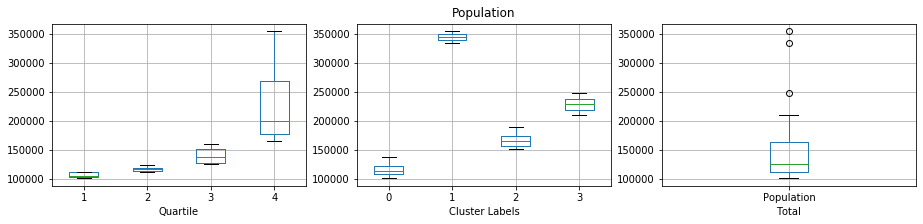

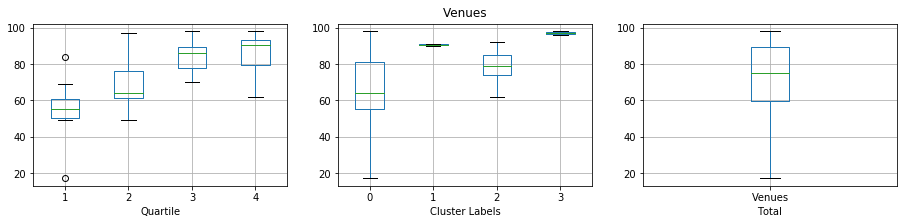

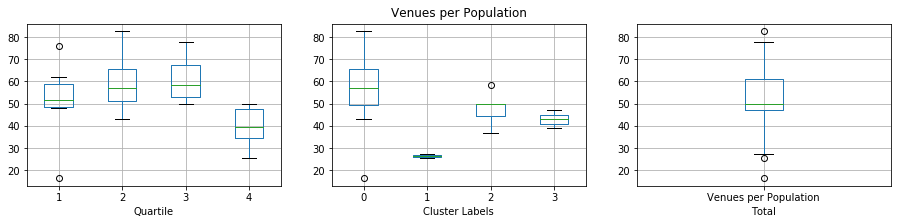

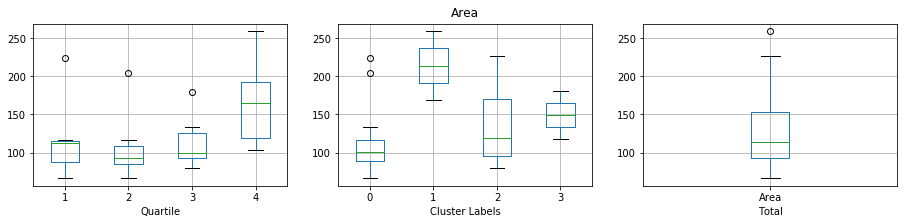

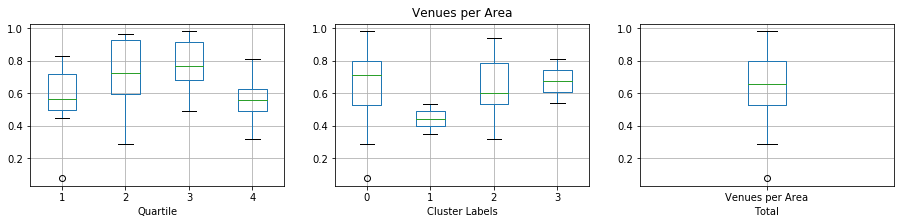

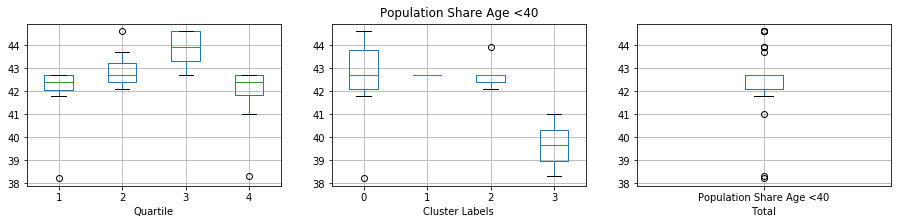

In [16]:
cols = ['Population', 'Venues', 'Venues per Population', 'Area', 'Venues per Area', 'Population Share Age <40']

for i in range(len(cols)):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
    cities_age_venues_grouped_less100.boxplot(
        column=cols[i],
        by='Quartile',
        ax=ax1,
        grid=True
    )
    cities_age_venues_grouped_less100.boxplot(
        column=cols[i],
        by='Cluster Labels',
        ax=ax2,
        grid=True
    )
    cities_age_venues_grouped_less100.boxplot(
        column=cols[i],
        ax=ax3,
        grid=True
    )
    fig.suptitle(str(cols[i]))
    ax1.set_title('')
    ax2.set_title('')
    ax3.set_xlabel('Total')
    plt.show()

The biggest accordance and also difference between the manual clustering and the k-means clustering is by the population data.
Both methods have the statistically best split between the groups within the population size, as the boxplots for the groups of each method do not overlap at all.
This comes as no surprise for the manual method, as we deliberately split the groups by quartiles of the population size.
The K-means on the other hand seems to use the population size as the most important factor for the split, but does not split the cities into equal sized groups.

The medians of Venues per Population and Venues per Area data are lowest for the largest cities in both k-means cluster 2 and population quartile 4. The K-means cluster 2 sets itself apart from the other clusters even better than quartile 4 from the quartile groups. 

The Age Share <40 of quartile 4 / cluster label 1 does not differ significantly to at least on other group, respectively the median of all cities combined.

***Remark: A re-run of the notebook led to a change in the K-means cluster label from 2 to 1. The report and presentation refer to cluster label 2.***

In [17]:
cols = ['Cluster Labels', 'Quartile', 'City', 'Population', 'Venues', 'Venues per Population', 'Population Share Age <40', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']
df_q4 = cities_age_venues_grouped_less100[cities_age_venues_grouped_less100['Quartile']==4]
df_q4[cols]

,Cluster Labels,Quartile,City,Population,Venues,Venues per Population,Population Share Age <40,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,1,4,Wuppertal,354382,90.0,25.396324,42.7,Supermarket,Café,Bar,Gas Station,Clothing Store
17,1,4,Bielefeld,333786,91.0,27.262977,42.7,Supermarket,Hotel,Train Station,Bar,Bakery
25,2,4,Hagen,188814,92.0,48.725200,42.7,Supermarket,Bakery,Clothing Store,Hotel,Café
26,2,4,Hamm,179111,72.0,40.198536,42.7,Supermarket,Drugstore,Ice Cream Shop,Bakery,Big Box Store
60,2,4,Oldenburg Oldb,168210,62.0,36.858689,42.1,Café,German Restaurant,Italian Restaurant,Big Box Store,Middle Eastern Restaurant
61,2,4,Osnabrueck,164748,82.0,49.772987,42.1,Supermarket,Bar,Hotel,Café,Nightclub
66,3,4,Kiel,247548,96.0,38.780358,41.0,Café,Supermarket,Gas Station,Hotel,Drugstore
76,3,4,Rostock,208886,98.0,46.915542,38.3,Hotel,Supermarket,Restaurant,Café,Big Box Store


In [18]:
df_ckm = cities_age_venues_grouped_less100[cities_age_venues_grouped_less100['Cluster Labels']==1]
df_ckm[cols]

,Cluster Labels,Quartile,City,Population,Venues,Venues per Population,Population Share Age <40,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,1,4,Wuppertal,354382,90.0,25.396324,42.7,Supermarket,Café,Bar,Gas Station,Clothing Store
17,1,4,Bielefeld,333786,91.0,27.262977,42.7,Supermarket,Hotel,Train Station,Bar,Bakery


**Both cities of the cluster label 1 are in the group of quartile 4. This is because they have the largest population of all 35 cities and are therefore in the fourth quartile = top 25% by population size.**

#### Map the cities of quartile 4 / cluster label 1

In [19]:
# create a blank map
map_fed_cities = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# generate choropleth map
map_fed_cities.choropleth(
    geo_data=r'bundeslaender_simplify200.geojson',
    data=cities_age_venues_grouped,
    columns=['State' , 'Population Share Age <40'],
    key_on='feature.properties.GEN',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Share Age <40 years of age'
)


# add markers to the map
for lat, lon, city in zip(df_ckm['Latitude'], df_ckm['Longitude'], df_ckm['City']):
    label = folium.Popup(str(city), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color='blue',
        fill=True, fill_opacity=1).add_to(map_fed_cities)

for lat, lon, city in zip(df_q4['Latitude'], df_q4['Longitude'], df_q4['City']):
    label = folium.Popup(str(city), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color='red',
        fill=False).add_to(map_fed_cities)

map_fed_cities

/home/lars/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


#### Comparison of the top venues of the K-means clustered data
The comparison of the venue categories will be limited to the top 5 venues and the top 5 cities of the K-means cluster 0 and both cities of cluster 2.

In [20]:
df_ckml = cities_age_venues_grouped_less100[cities_age_venues_grouped_less100['Cluster Labels']==0]
df_ckmh = cities_age_venues_grouped_less100[cities_age_venues_grouped_less100['Cluster Labels']==1]

df_topvenues = pd.concat([
    df_ckml.loc[:, ['Cluster Labels', 'City', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']].head(5),
    df_ckmh.loc[:, ['Cluster Labels', 'City', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']].head(5)])
df_topvenues

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,0,Ingolstadt,Supermarket,German Restaurant,Italian Restaurant,Café,Drugstore
32,0,Bottrop,Supermarket,Hotel,Clothing Store,Café,Drugstore
33,0,Recklinghausen,Supermarket,Drugstore,Café,Clothing Store,Italian Restaurant
34,0,Bergisch Gladbach,Supermarket,Drugstore,Hotel,Italian Restaurant,Hardware Store
35,0,Remscheid,Supermarket,Gas Station,Café,German Restaurant,Drugstore
16,1,Wuppertal,Supermarket,Café,Bar,Gas Station,Clothing Store
17,1,Bielefeld,Supermarket,Hotel,Train Station,Bar,Bakery


The supermarket category dominates the 1st most common venues.
Apart from that, one can note that in group 'cluster label 0' more 'store-like' venues (Drugstore, Clothing Store, Hardware Store,...) are represented than in group 'cluster label 1'.

On the other hand, in group 'cluster label 1' more 'travel-related' and 'touristic' venues like hotels and cafés dominated the 2nd to 5th most common venues.

## 5. Results and discussion

The analysis shows that 'manual' clustering by 'gut' using the most obvious data columns and a splitting into quartiles is **not a necessarily useless first approach** when compared to the K-means ML method.

Plotting the different clusters against each other and for the different variables, I chose the parameter 'Venues per Population' as the significant parameter for identifying the cities that have the biggest potential in expanding the Foursquare user base e.g. by advertising the usage of Foursquare.

The resulting dataframe of cities with the 25% largest population size **(quartile 4) includes 9 cities**.
These 9 cities are located mainly in the northern half of Germany and in the western states as well as in the eastern federal states.

When using the K-means method, **cluster 2 with only two cities sticks out**. This cluster (label 1) includes the cities **Bielefeld and Wuppertal**, which have large population but also a low count of venues. Thus resulting in very low 'Venues per Population' values.

The 'manually' grouped cluster 'quartile 4' includes these cities as well. **But the K-means method helped to narrow down the group of cities to be targeted by advertisement to 2 instead of 9 cities.**

When comparing the type of venues of the cities Wuppertal and Bielefeld to the K-means cluster 0, which includes the highest 'Venues per Population' values, one notes that no 'stores' are represented in the top 5 venues in Wuppertal and Bielefeld.

## 6. Conclusion

Concluding this project I'd like to look at the questions that were stated in the business problem chapter and answer them:


* How much and what type of Foursquare Places data can a data scientist use to compare German cities? What are the limits of this comparison?
   * **When using Foursquare's API the 'common' data scientist is limited to 100 venues per API call. This limit may be bypassed by using a smaller search radius and multiple searches per city.**
   * Apart from that, the usual variety of Foursquare data can be used. In this project, I limited myself to the venue (category) data.
   * The age share data probably does not necessarily represent the age structure of the cities, as it was compiled on federal state level and not on city level.
   
   
* Can one cluster the cities to enable data scientist to decide which cities are better suited for comparison than others? In which properties do the city clusters differ?
   * Probably all cities which are limited by the Foursquare API call to 100 venues have a large enough Foursquare database to be used for comparison as usual.
   * **If you focus on the cities with less than 100 venues per API call, the largest (by population) of these cities tend to have a low venue per population count. These cities probably have a small Foursquare database compared to the potential user base**.
   * **The cities of cluster 2, Wuppertal and Bielefeld, don't have any 'store'-like venues in their top 5 venues.**


* Can one select cities that should be targeted with an ad campaign to promote the usage of Foursquare to expand the database?
   * **The cities of cluster 2, Wuppertal and Bielefeld, should be targeted, because they have quite a large population (>300,000 inhabitants) and a high share of young people, which, to me, are the factors for a large potential Foursquare user base**.